In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
# importing the necessary libraries for the project
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, log_loss,  confusion_matrix
from sklearn.decomposition import PCA

In [3]:
# Load the datasets
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
sample = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [4]:
# Make copies of the original datasets
movies_copy = movies.copy()
sample_copy = sample.copy()
test_copy = test.copy()
train_copy = train.copy()

In [5]:
movies_copy.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [6]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [7]:
movies_copy.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [8]:
movies_copy.shape

(143258, 14)

In [9]:
movies_copy.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [10]:
train_copy.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [11]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [12]:
train_copy.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [13]:
train_copy.shape

(162758, 5)

In [14]:
train_copy.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [15]:
test_copy.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [16]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [17]:
test_copy.describe()

,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


In [18]:
test_copy.shape

(55315, 4)

In [19]:
test_copy.isnull().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [20]:
# lets visualize the features/attributes of the datasets
import seaborn as sns
import matplotlib.pyplot as plt

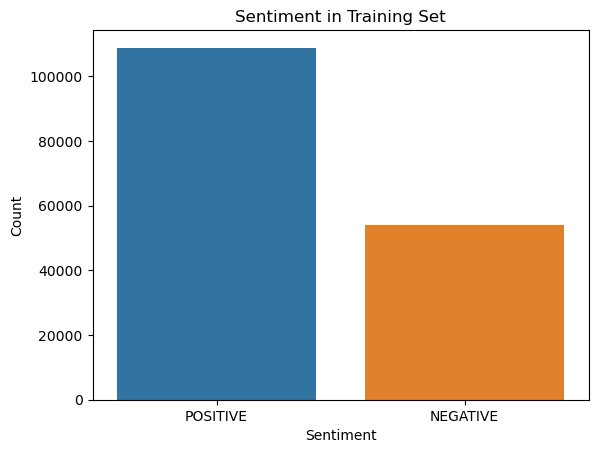

In [21]:
# Data Visualizations in train dataset with respect to sentiment count.
sns.countplot(x="sentiment", data=train_copy)
plt.title("Sentiment in Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

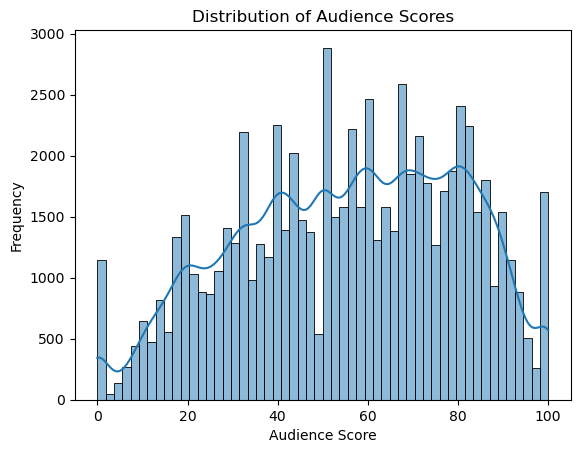

In [22]:
# Filter out missing values from audienceScore column
audience_scores = movies_copy['audienceScore'].dropna()

# Create a histogram
sns.histplot(audience_scores, kde=True)
plt.xlabel('Audience Score')
plt.ylabel('Frequency')
plt.title('Distribution of Audience Scores')
plt.show()

In [23]:
train_copy

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE
...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE


In [24]:
# Check for duplicate entries
are_duplicates = movies_copy.duplicated().any()

if are_duplicates:
    print("Duplicate entries exist in the movies dataset.")
else:
    print("No duplicate entries found in the movies dataset.")

duplicate_count = movies_copy.duplicated().sum()
print(f"Number of duplicate entries: {duplicate_count}")

duplicate_mask = movies_copy.duplicated(keep=False)  # keep=False marks all duplicates as True
duplicate_entries = movies_copy[duplicate_mask]

print("Duplicate Entries:")
print(duplicate_entries)

Duplicate entries exist in the movies dataset.
Number of duplicate entries: 1571
Duplicate Entries:
                                                 movieid  \
277                                supreme_indiana_jones   
871          escape_the_terminator_tyler_durden_astonish   
913                           oracle_darth_vader_gandalf   
1126         escape_the_terminator_tyler_durden_astonish   
2447                         e.t._starlight_tony_montana   
...                                                  ...   
140598  cosmic_jack_torrance_ellis_redding_indiana_jones   
140654      the_bride_hannibal_lecter_enigma_black_widow   
141470                  wolverine_tony_montana_wolverine   
142468       escape_the_terminator_tyler_durden_astonish   
143139             quest_rick_blaine_wonder_jason_bourne   

                                                   title  audienceScore  \
277                                Supreme Indiana Jones            NaN   
871          Escape The Termi

In [25]:
new_movies_copy=movies_copy.drop_duplicates()
new_movies_copy.shape

(141687, 14)

In [26]:
# Check for duplicate entries
are_duplicates = train_copy.duplicated().any()

if are_duplicates:
    print("Duplicate entries exist in the movies dataset.")
else:
    print("No duplicate entries found in the movies dataset.")

duplicate_count = train_copy.duplicated().sum()
print(f"Number of duplicate entries: {duplicate_count}")

Duplicate entries exist in the movies dataset.
Number of duplicate entries: 1118


In [27]:
# Find and display duplicate entries
duplicate_mask = train_copy.duplicated(keep=False)  # keep=False marks all duplicates as True
duplicate_entries = train_copy[duplicate_mask]

print("Duplicate Entries:")
print(duplicate_entries)

Duplicate Entries:
                                                  movieid       reviewerName  \
55                     tony_stark_celestial_frodo_baggins     Tyler Marshall   
196         morpheus_enthralling_radiant_michael_corleone     Debbie Bennett   
283                                 wolverine_spectacular       Jesus Miller   
292                              miracle_john_wick_pirate  Rhonda Washington   
320     holly_golightly_princess_leia_hannibal_lecter_...     Yvonne Mendoza   
...                                                   ...                ...   
162421                              epic_hulk_marty_mcfly    Larry Patterson   
162441                 marty_mcfly_dorothy_gale_marvelous        Tammy Welch   
162451              jon_snow_tony_montana_sherlock_holmes       Carl Vaughan   
162489         sorcerer_darth_vader_sapphire_tony_montana        Lauren Dunn   
162579       captain_jack_sparrow_destiny_tony_stark_hulk    Sherri Morrison   

        isFrequentRe

In [28]:
new_train_copy=train_copy.drop_duplicates()
new_train_copy.shape

(161640, 5)

In [29]:
# Get unique 'movieid' values from the train dataset
unique_movieids = new_train_copy['movieid'].unique()

# Filter the 'movies' dataset based on unique 'movieid' values
filtered_movies = new_movies_copy[new_movies_copy['movieid'].isin(unique_movieids)]

In [30]:
# Merge train and movies dataframes
# The reason for using left merging is that we want to keep all the rows from the 'train' DataFrame and merge only the matching rows from the 'movies' DataFrame based on the 'movieid' column.
#  we keep all the data from the 'train' DataFrame while incorporating additional movie information from the 'movies' DataFrame where possible.
merged_data = pd.merge(new_train_copy, filtered_movies, on='movieid', how='left')

In [31]:
# Remove duplicate rows
merged_data.drop_duplicates(inplace=True)

In [32]:
# Basic Statistics
print("Data shape:")
print(merged_data.shape)

Data shape:
(307979, 18)


In [33]:
print("\nData info:")
print(merged_data.info())


Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307979 entries, 0 to 307978
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               307979 non-null  object 
 1   reviewerName          307979 non-null  object 
 2   isFrequentReviewer    307979 non-null  bool   
 3   reviewText            295024 non-null  object 
 4   sentiment             307979 non-null  object 
 5   title                 307979 non-null  object 
 6   audienceScore         216573 non-null  float64
 7   rating                129370 non-null  object 
 8   ratingContents        129370 non-null  object 
 9   releaseDateTheaters   175695 non-null  object 
 10  releaseDateStreaming  241608 non-null  object 
 11  runtimeMinutes        293557 non-null  float64
 12  genre                 298870 non-null  object 
 13  originalLanguage      295807 non-null  object 
 14  director              307979 non-null  o

In [34]:
print("\nData description:")
print(merged_data.describe())


Data description:
       audienceScore  runtimeMinutes
count  216573.000000   293557.000000
mean       63.231636      102.419281
std        20.977627       25.884408
min         0.000000        2.000000
25%        48.000000       90.000000
50%        66.000000      100.000000
75%        80.000000      115.000000
max       100.000000      561.000000


In [35]:
# Check for missing values
print("\nMissing Values:")
print(merged_data.isnull().sum())


Missing Values:
movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText               12955
sentiment                    0
title                        0
audienceScore            91406
rating                  178609
ratingContents          178609
releaseDateTheaters     132284
releaseDateStreaming     66371
runtimeMinutes           14422
genre                     9109
originalLanguage         12172
director                     0
boxOffice               168445
distributor             144587
soundType               202424
dtype: int64


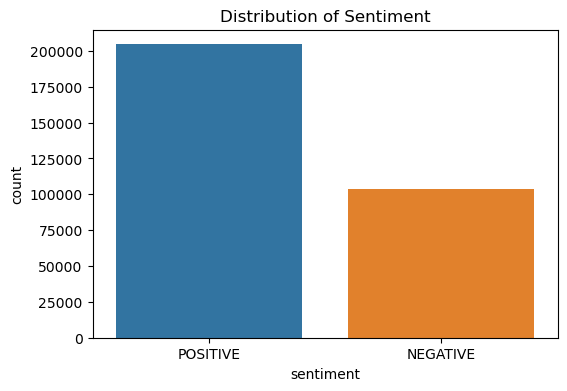

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(data=merged_data, x='sentiment')
plt.title('Distribution of Sentiment')
plt.show()

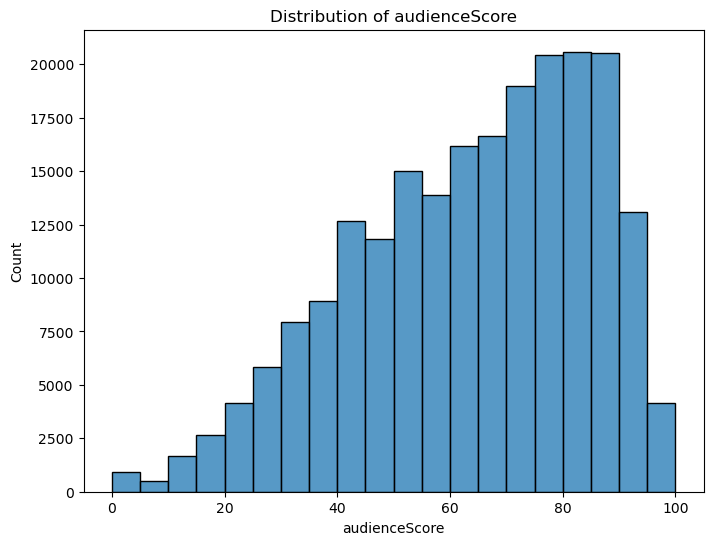

In [37]:
# Distribution of audienceScore
plt.figure(figsize=(8, 6))
sns.histplot(data=merged_data, x='audienceScore', bins=20)
plt.title('Distribution of audienceScore')
plt.show()

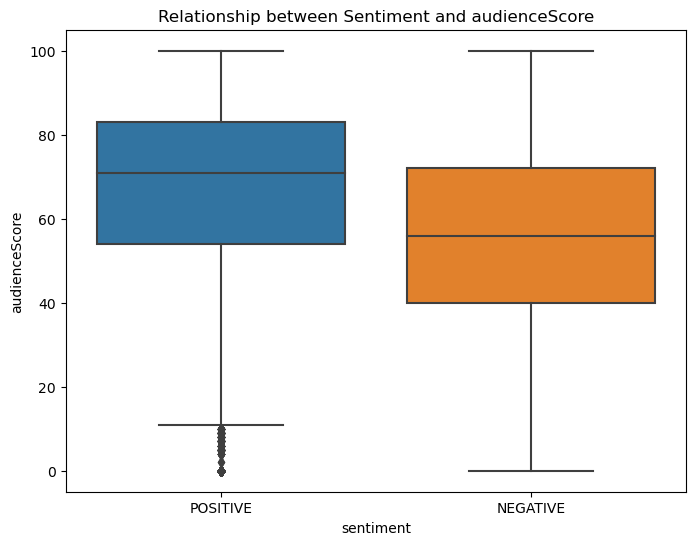

In [38]:
# Relationship between audienceScore and sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_data, x='sentiment', y='audienceScore')
plt.title('Relationship between Sentiment and audienceScore')
plt.show()

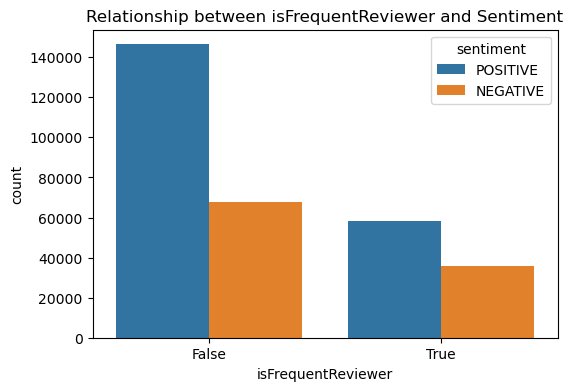

In [39]:
# Relationship between isFrequentReviewer and sentiment
plt.figure(figsize=(6, 4))
sns.countplot(data=merged_data, x='isFrequentReviewer', hue='sentiment')
plt.title('Relationship between isFrequentReviewer and Sentiment')
plt.show()

In [40]:
# Check for missing values
print("Missing Values in Merged Data:")
print(merged_data.isnull().sum())

Missing Values in Merged Data:
movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText               12955
sentiment                    0
title                        0
audienceScore            91406
rating                  178609
ratingContents          178609
releaseDateTheaters     132284
releaseDateStreaming     66371
runtimeMinutes           14422
genre                     9109
originalLanguage         12172
director                     0
boxOffice               168445
distributor             144587
soundType               202424
dtype: int64


In [41]:
mean_audience_score = merged_data['audienceScore'].mean()
merged_data['audienceScore'].fillna(mean_audience_score, inplace=True)

In [42]:
# Impute missing values for 'isFrequentReviewer' using mode imputation
mode_is_frequent_reviewer = merged_data['isFrequentReviewer'].mode()[0]
merged_data['isFrequentReviewer'].fillna(mode_is_frequent_reviewer, inplace=True)

In [43]:
# After imputation, check if there are any remaining missing values
print("\nMissing Values after Imputation:")
print(merged_data.isnull().sum())


Missing Values after Imputation:
movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText               12955
sentiment                    0
title                        0
audienceScore                0
rating                  178609
ratingContents          178609
releaseDateTheaters     132284
releaseDateStreaming     66371
runtimeMinutes           14422
genre                     9109
originalLanguage         12172
director                     0
boxOffice               168445
distributor             144587
soundType               202424
dtype: int64


In [44]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Scaling Numerical Features (audienceScore)
scaler = StandardScaler()
merged_data['audienceScore'] = scaler.fit_transform(merged_data[['audienceScore']])

In [45]:
# Encoding Categorical Features (isFrequentReviewer)
label_encoder = LabelEncoder()
merged_data['isFrequentReviewer'] = label_encoder.fit_transform(merged_data['isFrequentReviewer'])

In [46]:
# Data Preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        return ''
    else:
        # Convert text to lowercase
        text = text.lower()

        # Remove non-alphanumeric characters except full stops and commas
        text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text)

        # Remove any extra spaces
        text = re.sub(r'\s+', ' ', text)

        return text

# Apply text preprocessing on reviewText column
merged_data['reviewText'] = merged_data['reviewText'].apply(preprocess_text)


In [47]:
merged_data.shape

(307979, 18)

In [48]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307979 entries, 0 to 307978
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               307979 non-null  object 
 1   reviewerName          307979 non-null  object 
 2   isFrequentReviewer    307979 non-null  int64  
 3   reviewText            307979 non-null  object 
 4   sentiment             307979 non-null  object 
 5   title                 307979 non-null  object 
 6   audienceScore         307979 non-null  float64
 7   rating                129370 non-null  object 
 8   ratingContents        129370 non-null  object 
 9   releaseDateTheaters   175695 non-null  object 
 10  releaseDateStreaming  241608 non-null  object 
 11  runtimeMinutes        293557 non-null  float64
 12  genre                 298870 non-null  object 
 13  originalLanguage      295807 non-null  object 
 14  director              307979 non-null  object 
 15  

In [49]:
merged_data.describe()

,isFrequentReviewer,audienceScore,runtimeMinutes
count,307979.000000,3.079790e+05,293557.000000
mean,0.304459,7.816503e-17,102.419281
std,0.460179,1.000002e+00,25.884408
min,0.000000,-3.594491e+00,2.000000
25%,0.000000,-4.110925e-01,90.000000
50%,0.000000,0.000000e+00,100.000000
75%,1.000000,6.689893e-01,115.000000
max,1.000000,2.090150e+00,561.000000


In [50]:
merged_data.isnull().sum()

movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText                   0
sentiment                    0
title                        0
audienceScore                0
rating                  178609
ratingContents          178609
releaseDateTheaters     132284
releaseDateStreaming     66371
runtimeMinutes           14422
genre                     9109
originalLanguage         12172
director                     0
boxOffice               168445
distributor             144587
soundType               202424
dtype: int64

In [51]:
# Drop columns with a large number of missing values
merged_data.drop(['rating', 'ratingContents'], axis=1, inplace=True)

In [52]:
# Impute missing values for 'releaseDateTheaters' and 'releaseDateStreaming' with the mode
merged_data['releaseDateTheaters'].fillna(merged_data['releaseDateTheaters'].mode()[0], inplace=True)
merged_data['releaseDateStreaming'].fillna(merged_data['releaseDateStreaming'].mode()[0], inplace=True)

In [53]:
# Impute missing values for 'runtimeMinutes' with the median
median_runtime = merged_data['runtimeMinutes'].median()
merged_data['runtimeMinutes'].fillna(median_runtime, inplace=True)

In [54]:
# Impute missing values for 'genre' and 'originalLanguage' with the mode
merged_data['genre'].fillna(merged_data['genre'].mode()[0], inplace=True)
merged_data['originalLanguage'].fillna(merged_data['originalLanguage'].mode()[0], inplace=True)

In [55]:
# For 'boxOffice' and 'distributor', we may need more context or domain knowledge to decide on imputation strategies
# For simplicity, we'll drop these columns as well
merged_data.drop(['boxOffice', 'distributor'], axis=1, inplace=True)

In [56]:
merged_data.shape

(307979, 14)

In [57]:
merged_data.isnull().sum()

movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText                   0
sentiment                    0
title                        0
audienceScore                0
releaseDateTheaters          0
releaseDateStreaming         0
runtimeMinutes               0
genre                        0
originalLanguage             0
director                     0
soundType               202424
dtype: int64

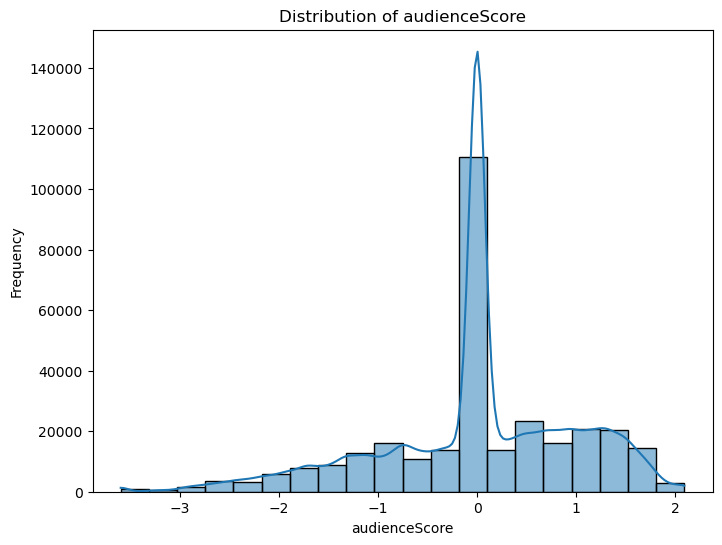

In [58]:
# Distribution of 'audienceScore'
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['audienceScore'], bins=20, kde=True)
plt.title('Distribution of audienceScore')
plt.xlabel('audienceScore')
plt.ylabel('Frequency')
plt.show()

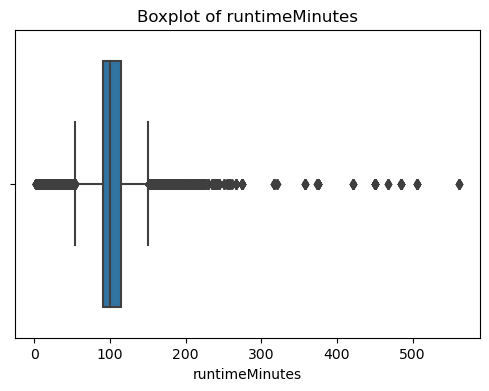

In [59]:
# Boxplot to identify outliers in 'runtimeMinutes'
plt.figure(figsize=(6, 4))
sns.boxplot(data=merged_data, x='runtimeMinutes')
plt.title('Boxplot of runtimeMinutes')
plt.show()

In [60]:
# Data Preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        return ''
    else:
        # Convert text to lowercase
        text = text.lower()

        # Remove non-alphanumeric characters except full stops and commas
        text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text)

        # Remove any extra spaces
        text = re.sub(r'\s+', ' ', text)

        return text

# Apply text preprocessing on reviewText column
train['reviewText'] = train['reviewText'].apply(preprocess_text)
test['reviewText'] = test['reviewText'].apply(preprocess_text)

In [61]:
# Use Stratified Shuffle Split for 5-fold cross-validation
stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=120)

In [62]:
# Initialize lists to store evaluation metrics from each fold
train_log_losses = []
test_log_losses = []
accuracies = []

In [63]:
for train_index, test_index in stratified_split.split(merged_data['reviewText'], merged_data['sentiment']):
    X_train, X_test = merged_data.iloc[train_index]['reviewText'], merged_data.iloc[test_index]['reviewText']
    y_train, y_test = merged_data.iloc[train_index]['sentiment'], merged_data.iloc[test_index]['sentiment']

In [64]:
# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_vectorized = vectorizer.transform(X_test)

In [65]:
# The resulting X_train_vectorized and X_test_vectorized matrices contain numerical representations of the text data, where each row corresponds to a document (movie review) and each column represents a unique word in the vocabulary. The values in the matrix represent the importance (TF-IDF score) of each word in each document, which can be used as input features for machine learning models.

In [66]:
X_train_vectorized.shape

(246383, 88805)

In [67]:
X_test_vectorized.shape

(61596, 88805)

In [68]:
y_train.shape

(246383,)

In [69]:
y_test.shape

(61596,)

In [70]:
from sklearn.pipeline import make_pipeline

In [71]:
# Build logistic regression model
pipeline = make_pipeline(LogisticRegression())

In [72]:
# Define the hyperparameters to tune
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  # Try different regularization strengths
    'logisticregression__penalty': ['l2'],  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'saga'],  # Solvers for optimization
    'logisticregression__max_iter': [3000,3500,4500],  # Maximum number of iterations for optimization
    'logisticregression__class_weight': [None, 'balanced'],  # Weight classes to address class imbalance
}

In [73]:
# Perform Randomized Search Cross-Validation
randomized_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, n_iter=5, random_state=42)
randomized_search.fit(X_train_vectorized, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('logisticregression',
                                              LogisticRegression())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.1, 1, 10],
                                        'logisticregression__class_weight': [None,
                                                                             'balanced'],
                                        'logisticregression__max_iter': [3000,
                                                                         3500,
                                                                         4500],
                                        'logisticregression__penalty': ['l2'],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'saga']},
                   random_state=42, scoring='accuracy')

In [74]:
# Get the best hyperparameters and the best score
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best CV Score:", best_score)

Best Hyperparameters: {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 4500, 'logisticregression__class_weight': None, 'logisticregression__C': 10}
Best CV Score: 0.8712127201858559


In [75]:
# Fit the model with best hyperparameters on the full training data
best_model = randomized_search.best_estimator_
best_model.fit(X_train_vectorized, y_train)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=10, max_iter=4500, solver='saga'))])

In [76]:
# Predict on the training and testing data
y_train_pred = best_model.predict(X_train_vectorized)
y_test_pred = best_model.predict(X_test_vectorized)

In [77]:
# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.9254494019473746
Test Accuracy: 0.8780927332943698


In [78]:
# 1. Loss Function (Logistic Regression uses Log-Loss)
# Already imported log_loss from sklearn.metrics

# Predict probabilities for the training and testing data
y_train_prob = best_model.predict_proba(X_train_vectorized)
y_test_prob = best_model.predict_proba(X_test_vectorized)

# Calculate log loss for training and testing data
train_log_loss = log_loss(y_train, y_train_prob)
test_log_loss = log_loss(y_test, y_test_prob)

print("Train Log Loss:", train_log_loss)
print("Test Log Loss:", test_log_loss)

Train Log Loss: 0.2062634391328471
Test Log Loss: 0.2927192352962138


In [79]:
# Apply text preprocessing to the test data
test_reviews = test['reviewText'].apply(preprocess_text)

# Transform the preprocessed test data using the TfidfVectorizer
test_reviews_vectorized = vectorizer.transform(test_reviews)

# Predict on the test data
test_predictions = best_model.predict(test_reviews_vectorized)

In [80]:
test_predictions

array(['POSITIVE', 'POSITIVE', 'POSITIVE', ..., 'POSITIVE', 'POSITIVE',
       'NEGATIVE'], dtype=object)

In [81]:
test_predictions.shape

(55315,)

In [82]:
# Predict on the test data using the logistic regression model
lr_test_predictions = best_model.predict(X_test_vectorized)

In [83]:
lr_test_accuracy = accuracy_score(y_test, lr_test_predictions)
lr_test_accuracy

0.8780927332943698

In [84]:
# Create a new DataFrame with movieid and predicted sentiment for logistic regression
lr_submission_df = pd.DataFrame({'id': range(len(test)), 'sentiment': test_predictions})

# Save the logistic regression submission file
lr_submission_df.to_csv('lr_submission.csv', index=False)

In [85]:
from sklearn.svm import LinearSVC

In [86]:
# Build pipeline with SVC
pipeline_svc = make_pipeline(LinearSVC())

param_grid_svc = {
    'linearsvc__C': [0.01, 0.1, 1, 10],  # Try different regularization strengths
    'linearsvc__loss': ['hinge', 'squared_hinge'],  # Loss function options
    'linearsvc__max_iter': [1500, 2500, 3000],  # Maximum number of iterations for optimization
    'linearsvc__dual': [False, True],  # Use dual or primal formulation
    'linearsvc__multi_class': ['ovr', 'crammer_singer'],  # Multi-class strategy options
    'linearsvc__fit_intercept': [True, False],  # Whether to fit an intercept term
}

In [87]:
# Perform Randomized Search Cross-Validation for SVC
randomized_search_svc = RandomizedSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1, n_iter=5, random_state=42)
randomized_search_svc.fit(X_train_vectorized, y_train)

RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('linearsvc', LinearSVC())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'linearsvc__C': [0.01, 0.1, 1, 10],
                                        'linearsvc__dual': [False, True],
                                        'linearsvc__fit_intercept': [True,
                                                                     False],
                                        'linearsvc__loss': ['hinge',
                                                            'squared_hinge'],
                                        'linearsvc__max_iter': [1500, 2500,
                                                                3000],
                                        'linearsvc__multi_class': ['ovr',
                                                                   'crammer_singer']},
                   random_state=42, scoring='accuracy')

In [88]:
# Get the best hyperparameters and the best score
best_params_svc = randomized_search_svc.best_params_
best_score_svc = randomized_search_svc.best_score_
print("Best Hyperparameters for LinearSVC:", best_params_svc)
print("Best Score for LinearSVC:", best_score_svc)

Best Hyperparameters for LinearSVC: {'linearsvc__multi_class': 'crammer_singer', 'linearsvc__max_iter': 3000, 'linearsvc__loss': 'squared_hinge', 'linearsvc__fit_intercept': False, 'linearsvc__dual': True, 'linearsvc__C': 1}
Best Score for LinearSVC: 0.8577093452218503


In [89]:
# Fit the LinearSVC model with best hyperparameters on the full training data
best_svc_model = randomized_search_svc.best_estimator_
best_svc_model.fit(X_train_vectorized, y_train)

Pipeline(steps=[('linearsvc',
                 LinearSVC(C=1, fit_intercept=False, max_iter=3000,
                           multi_class='crammer_singer'))])

In [90]:
# Predict on the training and testing data
y_train_pred_svc = best_svc_model.predict(X_train_vectorized)
y_test_pred_svc = best_svc_model.predict(X_test_vectorized)

In [91]:
# Evaluate the model
train_accuracy_svc = accuracy_score(y_train, y_train_pred_svc)
test_accuracy_svc = accuracy_score(y_test, y_test_pred_svc)

print("Train Accuracy for LinearSVC:", train_accuracy_svc)
print("Test Accuracy for LinearSVC:", test_accuracy_svc)

Train Accuracy for LinearSVC: 0.9074449130013028
Test Accuracy for LinearSVC: 0.8659977920644197


In [92]:
#calculating hing-loss for training 
from sklearn.metrics import hinge_loss

# Get the best LinearSVC model from the randomized search
best_svc_model = randomized_search_svc.best_estimator_.named_steps['linearsvc']

# Predict the decision function scores for the training data
decision_scores = best_svc_model.decision_function(X_train_vectorized)

# Calculate the hinge loss
loss = hinge_loss(y_train, decision_scores)

print("Hinge Loss:", loss)

Hinge Loss: 0.2092890867220194


In [93]:
# Predict the decision function scores for the test data
test_decision_scores = best_svc_model.decision_function(X_test_vectorized)

# Calculate the hinge loss for the test data
test_loss = hinge_loss(y_test, test_decision_scores)

print("Hinge Loss on Test Data:", test_loss)

Hinge Loss on Test Data: 0.30503006605575844


In [94]:
# Apply text preprocessing to the test data
test_reviews = test['reviewText'].apply(preprocess_text)

# Transform the preprocessed test data using the TfidfVectorizer
test_reviews_vectorized = vectorizer.transform(test_reviews)

# Predict on the test data using the best SVC model
test_predictions = best_svc_model.predict(test_reviews_vectorized)

In [95]:
# Predict on the test data using the LinearSVC model
svc_test_predictions = best_svc_model.predict(X_test_vectorized)

In [96]:
svc_test_accuracy = accuracy_score(y_test, svc_test_predictions)
svc_test_accuracy

0.8659977920644197

In [97]:
# Create a new DataFrame with movieid and predicted sentiment for SVC
svc_submission_df = pd.DataFrame({'id': range(len(test)), 'sentiment': test_predictions})

# Save the SVC submission file
svc_submission_df.to_csv('svc_submission.csv', index=False)

In [98]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(RandomForestClassifier())


In [99]:
param_dist = {
    'randomforestclassifier__n_estimators': [100, 150, 200],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [5, 10, 15],  # Maximum depth of each tree
    'randomforestclassifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
}


In [100]:
# Using RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_iter=2, random_state=75)
random_search.fit(X_train_vectorized, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=2,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt',
                                                                                 'log2'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 150,
                                                                                 200]},
                   random_state=75)

In [101]:
# Get the best hyperparameters and the best score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

In [102]:
# Fit the random forest model with best hyperparameters on the full training data
random_best_model = random_search.best_estimator_
random_best_model.fit(X_train_vectorized, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=150))])

In [103]:
# Predict on the training and testing data
y_train_pred = random_best_model.predict(X_train_vectorized)
y_test_pred = random_best_model.predict(X_test_vectorized)

In [104]:
# Evaluation Metrics
# Calculate log loss for training and testing data
y_train_prob = random_best_model.predict_proba(X_train_vectorized)
y_test_prob = random_best_model.predict_proba(X_test_vectorized)
train_log_loss = log_loss(y_train, y_train_prob)
test_log_loss = log_loss(y_test, y_test_prob)

In [105]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [106]:
# Append metrics to lists for each fold
train_log_losses.append(train_log_loss)
test_log_losses.append(test_log_loss)
accuracies.append(test_accuracy)

In [107]:
# Average evaluation metrics over the 5 folds
avg_train_log_loss = np.mean(train_log_losses)
avg_test_log_loss = np.mean(test_log_losses)
avg_accuracy = np.mean(accuracies)

In [108]:
print("Average Train Log Loss:", avg_train_log_loss)
print("Average Test Log Loss:", avg_test_log_loss)
print("Average Accuracy:", avg_accuracy)

Average Train Log Loss: 0.6245150993187287
Average Test Log Loss: 0.6250721208000095
Average Accuracy: 0.6641177998571336


In [109]:
# Predict on the test data
test_reviews = test['reviewText'].apply(preprocess_text)
test_reviews_vectorized = vectorizer.transform(test_reviews)
test_predictions = random_best_model.predict(test_reviews_vectorized)

In [110]:
# Predict on the test data using the logistic regression model
random_test_predictions = random_best_model.predict(X_test_vectorized)

In [111]:
random_test_accuracy = accuracy_score(y_test, random_test_predictions)
random_test_accuracy

0.6641177998571336

In [112]:
# Create a submission DataFrame
submission_df_rf = pd.DataFrame({'id': range(len(test)), 'sentiment': test_predictions})
# Save the submission to a CSV file
submission_df_rf.to_csv('submission_rf.csv', index=False)